# Benodigde libraries importeren

In [106]:
import pandas as pd
from datetime import datetime
import numpy as np
import pandas.api.types as ptypes


# Bestand inladen en data filteren

In [107]:
# excel bestand maxilia geimporteerd en kolommen gefilterd 

df = pd.read_csv(r'/Users/lisannepeeters/expdata 20190912 1002.csv', sep=None, delimiter=None, engine='python', usecols=['email','Orderdate','OrderID','TurnoverLead', 'BuyinLead'])
df.head()

,OrderID,Orderdate,email,TurnoverLead,BuyinLead
0,27654,22-4-2014,janneke.van.wingerden@hotmail.com,840.0,0.0
1,30777,9-4-2015,marloessanders@izit.nl,300.0,0.0
2,32291,30-7-2014,info@ferox-design.com,235.0,0.0
3,32291,30-7-2014,info@ferox-design.com,235.0,0.0
4,33824,27-5-2016,johan@thermservice.be,0.0,0.0


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273322 entries, 0 to 273321
Data columns (total 5 columns):
OrderID         273322 non-null int64
Orderdate       131183 non-null object
email           272921 non-null object
TurnoverLead    273322 non-null float64
BuyinLead       273322 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.4+ MB


In [109]:
# lege rijen 'NaT' eruit gefilterd 

df = df.dropna(axis=0, how = 'any', inplace=False)
df = df[~df['email'].str.contains('@')==False]
df.head()

,OrderID,Orderdate,email,TurnoverLead,BuyinLead
0,27654,22-4-2014,janneke.van.wingerden@hotmail.com,840.0,0.0
1,30777,9-4-2015,marloessanders@izit.nl,300.0,0.0
2,32291,30-7-2014,info@ferox-design.com,235.0,0.0
3,32291,30-7-2014,info@ferox-design.com,235.0,0.0
4,33824,27-5-2016,johan@thermservice.be,0.0,0.0


In [110]:
df['Orderdate']=pd.to_datetime(df['Orderdate'], format='%d-%m-%Y')


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131101 entries, 0 to 273321
Data columns (total 5 columns):
OrderID         131101 non-null int64
Orderdate       131101 non-null datetime64[ns]
email           131101 non-null object
TurnoverLead    131101 non-null float64
BuyinLead       131101 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 6.0+ MB


In [112]:
df.describe()

,OrderID,TurnoverLead,BuyinLead
count,131101.000000,131101.000000,131101.000000
mean,149286.727477,831.555278,501.378869
std,61005.961800,2563.766797,1917.248587
min,27654.000000,-392.000000,-1001.510000
25%,95795.000000,183.000000,44.000000
50%,150528.000000,355.000000,177.000000
75%,203514.000000,765.000000,448.000000
max,252808.000000,174519.500000,141338.840000


In [113]:
assert ptypes.is_datetime64_any_dtype(df['Orderdate'])
assert all(df[df['email'].str.contains('@')])


# Data grouperen per klant

In [114]:
# group by customer ID
# hoeveel orders zijn er gedaan per customer
# totale uitgaven per customer 

df_clv = df.groupby('email').agg({
                                                        'Orderdate': lambda date: (date.max() - date.min()).days,
                                                        'OrderID': lambda num: len(num), 
                                                        'TurnoverLead': lambda price: price.sum()
                                                    }) 
df_clv.head()

,Orderdate,OrderID,TurnoverLead
email,,,
00kippie@planet.nl,0,1,125.0
03vichy@gmail.com,0,1,259.0
06alexisbrunet@gmail.com,0,1,180.0
070paulus070@gmail.com,0,1,33.5
0910975@hr.nl,0,1,430.0


In [115]:
# rename kolommen 

df_clv.columns = ['days_customer', 'total_transactions', 'total_spent']
df_clv.head()

,days_customer,total_transactions,total_spent
email,,,
00kippie@planet.nl,0,1,125.0
03vichy@gmail.com,0,1,259.0
06alexisbrunet@gmail.com,0,1,180.0
070paulus070@gmail.com,0,1,33.5
0910975@hr.nl,0,1,430.0


In [116]:
df_clv.describe()

,days_customer,total_transactions,total_spent
count,72793.000000,72793.000000,7.279300e+04
mean,74.874370,1.801011,1.497640e+03
std,223.708098,2.755637,1.365772e+04
min,0.000000,1.000000,-7.840000e+02
25%,0.000000,1.000000,1.751600e+02
50%,0.000000,1.000000,3.500000e+02
75%,0.000000,2.000000,8.909000e+02
max,1723.000000,184.000000,2.105784e+06


# Berekenen van de totale CLV

In [117]:
# gemiddelde order waarde 

avg_order_value = sum(df_clv['total_spent']) / sum(df_clv['total_transactions'])
print(avg_order_value)

831.5552775341279


In [118]:
# hoe vaak koopt iemand gemiddeld iets

purchase_frequency = sum(df_clv['total_transactions']) / df_clv.shape[0]
print(purchase_frequency)

1.8010110862308188


In [119]:
# hoe vaak komt iemand terug

repeat_rate = df_clv[df_clv.total_transactions > 1].shape[0] / df_clv.shape[0] 
print(repeat_rate)

0.3038891102166417


In [120]:
# churnrate: hoeveel % doet na 1 aankoop geen bestelling meer

churn_rate = 1 - repeat_rate
print(churn_rate)

0.6961108897833583


In [121]:
# gemiddelde marge  

profit = sum(df['TurnoverLead']) - sum(df['BuyinLead'])
margin = profit / sum(df['TurnoverLead'])
    
print(margin)

0.3970588817930564


In [122]:
# totale clv & clv marge 
# in het blok hierboven is de marge berekend ('margin'), maar je kan ook een getal noteren ipv 'margin'

total_clv = (avg_order_value * purchase_frequency) / churn_rate 
total_clv_margin = total_clv * margin

print(total_clv) # het eerste getal is de totale clv
print(total_clv_margin) # het tweede getal is de clv waarbij rekening is gehouden met de berekende marge

2151.439225607864
854.2480531655776


In [123]:
# Bovenstaande cijfers in kolom neerzetten zodat de data in datastudio kan worden gebruikt
set_total_clv = avg_order_value, purchase_frequency, churn_rate, total_clv, total_clv_margin 
df_total_clv = pd.DataFrame(set_total_clv, columns= ['Waarde'], index = ['Gemiddelde orderwaarde' , 'Frequentie aankoop', 'Churn rate' , 'CLV', 'CLV marge'])
df_clv_values=df_total_clv.T.groupby(level=0).agg(lambda x : x.values.tolist()).stack().apply(pd.Series).unstack().sort_index(level=1,axis=1)
df_clv_values.columns=df_clv_values.columns.droplevel(level=0)
df_clv_values.head()

,CLV,CLV marge,Churn rate,Frequentie aankoop,Gemiddelde orderwaarde
Waarde,2151.439226,854.248053,0.696111,1.801011,831.555278


In [124]:
df_clv_values.to_excel('CLV_waardes.xlsx')

   # Transacties en churn rate per maand uiteenzetten

In [125]:
# transacties per klant per maand uiteenzetten
df_monthly = df.set_index('Orderdate')
df_monthly = df_monthly.pivot_table(
    index=['email'],
    columns=pd.Grouper(freq='M'),
    values='OrderID', 
    aggfunc='count',
    fill_value=0
)

# Format column headers to human readable format
df_monthly.columns = [x.strftime('%b-%Y') for x in df_monthly.columns]

df_monthly

,Apr-2014,Jul-2014,Sep-2014,Oct-2014,Nov-2014,Dec-2014,Jan-2015,Feb-2015,Mar-2015,Apr-2015,...,Dec-2018,Jan-2019,Feb-2019,Mar-2019,Apr-2019,May-2019,Jun-2019,Jul-2019,Aug-2019,Sep-2019
email,,,,,,,,,,,,,,,,,,,,,
00kippie@planet.nl,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
03vichy@gmail.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
06alexisbrunet@gmail.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
070paulus070@gmail.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
0910975@hr.nl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.NLD.MINUSMA.GAO.AHDET.COGP.S1@B-SC1.TTN.MINDEF.NL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.vorsitzende.gv.muenster@gmail.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.vs@ogv-asperg.de,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111856@student.drenthecollege.nl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
repeat_rate = df_monthly[df_monthly > 1].count() / df_monthly[df_monthly > 0].count()
df_churn = repeat_rate.to_frame(name='repeat_rate')

In [127]:
df_churn['churn_rate'] = 1 - df_churn['repeat_rate']
df_churn


,repeat_rate,churn_rate
Apr-2014,0.000000,1.000000
Jul-2014,1.000000,0.000000
Sep-2014,0.000000,1.000000
Oct-2014,0.333333,0.666667
Nov-2014,0.222222,0.777778
Dec-2014,0.157895,0.842105
Jan-2015,0.114478,0.885522
Feb-2015,0.129606,0.870394
Mar-2015,0.178311,0.821689
Apr-2015,0.169181,0.830819


# CLV per klant uitrekenen

In [128]:
# clv per customer

df_clv['customer_order_value'] = df_clv['total_spent'] / df_clv['total_transactions']
df_clv['customer_clv'] = (df_clv['customer_order_value'] * purchase_frequency) / churn_rate
df_clv['customer_clv_margin'] = df_clv['customer_clv'] * margin

df_clv.head()

,days_customer,total_transactions,total_spent,customer_order_value,customer_clv,customer_clv_margin
email,,,,,,
00kippie@planet.nl,0,1,125.0,125.0,323.405924,128.411195
03vichy@gmail.com,0,1,259.0,259.0,670.097075,266.067995
06alexisbrunet@gmail.com,0,1,180.0,180.0,465.704531,184.912120
070paulus070@gmail.com,0,1,33.5,33.5,86.672788,34.414200
0910975@hr.nl,0,1,430.0,430.0,1112.516380,441.734510


In [129]:
df_clv.describe()

,days_customer,total_transactions,total_spent,customer_order_value,customer_clv,customer_clv_margin
count,72793.000000,72793.000000,7.279300e+04,72793.000000,72793.000000,72793.000000
mean,74.874370,1.801011,1.497640e+03,547.447264,1416.381509,562.386858
std,223.708098,2.755637,1.365772e+04,1150.759735,2977.300127,1182.163459
min,0.000000,1.000000,-7.840000e+02,-392.000000,-1014.200979,-402.697507
25%,0.000000,1.000000,1.751600e+02,160.000000,413.959583,164.366329
50%,0.000000,1.000000,3.500000e+02,287.500000,743.833626,295.345748
75%,0.000000,2.000000,8.909000e+02,567.500000,1468.262897,582.986824
max,1723.000000,184.000000,2.105784e+06,110830.736842,286746.535182,113855.258617


In [130]:
df_clv.to_excel('CLV_per_klant.xlsx')

In [131]:
# Uiteenzetting uitgaves klanten per maand
df['month_yr'] = df['Orderdate'].apply(lambda x: x.strftime('%b-%Y'))
df.head()

,OrderID,Orderdate,email,TurnoverLead,BuyinLead,month_yr
0,27654,2014-04-22,janneke.van.wingerden@hotmail.com,840.0,0.0,Apr-2014
1,30777,2015-04-09,marloessanders@izit.nl,300.0,0.0,Apr-2015
2,32291,2014-07-30,info@ferox-design.com,235.0,0.0,Jul-2014
3,32291,2014-07-30,info@ferox-design.com,235.0,0.0,Jul-2014
4,33824,2016-05-27,johan@thermservice.be,0.0,0.0,May-2016


In [132]:
#totale transacties / opbrengst per maand

df_transacties = df.groupby('month_yr').aggregate({
                                                        'OrderID': lambda num: len(num), 
                                                        'TurnoverLead': lambda price: price.sum(),
                                                        'email': pd.Series.nunique
                                                    }) 
df_transacties.head()

,OrderID,TurnoverLead,email
month_yr,,,
Apr-2014,1,840.00,1
Apr-2015,1167,650938.60,928
Apr-2016,1543,1152839.06,1201
Apr-2017,1483,1147994.84,1132
Apr-2018,2755,2413270.00,2054


In [133]:
df_transacties.columns = ['total_transactions', 'total_spent', 'total_unique_customers']
df_transacties.head()

,total_transactions,total_spent,total_unique_customers
month_yr,,,
Apr-2014,1,840.00,1
Apr-2015,1167,650938.60,928
Apr-2016,1543,1152839.06,1201
Apr-2017,1483,1147994.84,1132
Apr-2018,2755,2413270.00,2054


In [134]:
df_transacties.describe()

,total_transactions,total_spent,total_unique_customers
count,63.000000,6.300000e+01,63.000000
mean,2080.968254,1.730440e+06,1562.476190
std,1178.428053,1.060242e+06,839.415942
min,1.000000,2.190000e+02,1.000000
25%,1343.500000,9.513474e+05,1052.500000
50%,1844.000000,1.534700e+06,1423.000000
75%,2861.500000,2.594284e+06,2104.500000
max,4962.000000,3.937462e+06,3679.000000


In [135]:
df_transacties.to_excel('Overzicht_per_maand.xlsx')

# CLV per maand berekenen

In [137]:
# CLV per maand berekenen
df_transacties['purchase_frequency_month'] = df_transacties['total_transactions'] / df_transacties['total_unique_customers']
df_transacties['avg_order_value_month'] = df_transacties['total_spent'] / df_transacties['total_transactions'] 
df_transacties['CLV'] = (df_transacties['avg_order_value_month'] * df_transacties['purchase_frequency_month']) / df_churn['churn_rate']
df_transacties['CLV_margin'] = df_transacties['CLV']*margin
df_transacties.head()

,total_transactions,total_spent,total_unique_customers,purchase_frequency_month,avg_order_value_month,CLV,CLV_margin
month_yr,,,,,,,
Apr-2014,1,840.00,1,1.000000,840.000000,840.000000,333.529461
Apr-2015,1167,650938.60,928,1.257543,557.788003,844.278340,335.228214
Apr-2016,1543,1152839.06,1201,1.284763,747.141322,1179.978567,468.520970
Apr-2017,1483,1147994.84,1132,1.310071,774.103061,1251.902770,497.079114
Apr-2018,2755,2413270.00,2054,1.341285,875.960073,1462.587879,580.733508


# Statistieken CLV per klant

In [35]:
# statistieken van clv per customer 

import statistics

df_clv_list = df_clv['customer_clv'].values

x1 = statistics.mean(df_clv_list) # eerste getal is gemiddelde
x2 = statistics.median(df_clv_list) # tweede getal is mediaan
x3 = statistics.mode(df_clv_list) # derde getal is de modus 
x4 = statistics.stdev(df_clv_list) # vierde getal is de standaarddeviatie 

print(x1) 
print(x2) 
print(x3) 
print(x4)

1416.381508584541
743.8336260656772
0.0
2977.3001273082336


In [36]:
# box plot: visuele weergaven van de verdeling van de clv 
# zichtbaar = minimum, maximum, mediaan en kwartielafstanden 

import matplotlib.pyplot as plt 
df_clv.plot(y = 'customer_clv', kind = 'box') 
plt.show()

<Figure size 640x480 with 1 Axes>

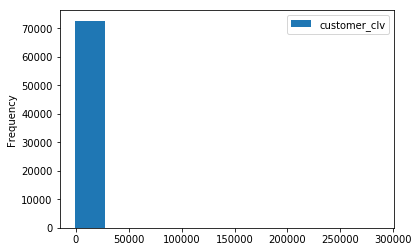

In [37]:
# histogram plot: visuele weergaven van frequentie verdeling van de clv 
# hoe vaak komt een clv waarde voor 

import matplotlib.pyplot as plt 
df_clv.plot(y = 'customer_clv', kind = 'hist') 
plt.show()